### %load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [21]:
import honk_sv.train as hk
from honk_sv import model as mod
from honk_sv import dataset as dset
from honk_sv import system as svs

# Dataframes
command: disjoint speaker split

In [4]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/speech_commands/'
data_df = pd.read_pickle(os.path.join(dataframe_dir,'Command_Dataframe.pkl'))

### Dataset split

In [9]:
#TODO: correct splits
all_spks = data_df.spk.unique()
all_sents = data_df.sent.unique()
uttrs_counts = data_df.spk.value_counts()
sv_spks = list(uttrs_counts.index[:10])
si_spks = list(uttrs_counts.index[10:])

In [19]:
import random 
si_df = data_df[data_df.spk.isin(si_spks)]

# command dataset is disjoint along speakers.
si_spk_train = si_df[si_df.set == 'train']
si_spk_val = si_df[si_df.set == 'val']
si_spk_test = si_df[si_df.set == 'test']
print("[spk] train:{}, val:{}, test:{}".format(len(si_spk_train), len(si_spk_val), len(si_spk_test)))=\

# spliting along the sents
random.shuffle(all_sents)
train_sent = all_sents[:25]
val_sent = all_sents[25:27]
test_sent = all_sents[27:]
si_sent_train = si_df[si_df.sent.isin(train_sent)]
si_sent_val = si_df[si_df.sent.isin(val_sent)]
si_sent_test = si_df[si_df.sent.isin(test_sent)]
print("[sent] train:{}, val:{}, test:{}".format(len(si_sent_train), len(si_sent_val), len(si_sent_test)))

# random sampling
si_random_train = si_df.sample(frac=0.8)
si_random_test = si_df.drop(index=si_random_train.index)
si_random_val = si_random_test.sample(frac=0.5)
si_random_test = si_random_test.drop(index=si_random_val.index)
print("[random] train:{}, val:{}, test:{}".format(len(si_random_train), len(si_random_val), len(si_random_test)))

[spk] train:51079, val:6798, test:6834
[sent] train:53494, val:4735, test:6482
[random] train:51769, val:6471, test:6471


# SI Train

In [31]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_random_train, 'val':si_random_val, 'test':si_random_test}
manifest_dir = "manifests/commands/"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("commands", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            label = si_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/commands/si_commands_train_manifest.csv was written
manifests/commands/si_commands_val_manifest.csv was written
manifests/commands/si_commands_test_manifest.csv was written


In [13]:
model = "cnn-trad-pool2"
dataset = "commands"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0,
                     n_epochs=100, batch_size=64,
                     lr=[0.01, 0.001], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001,
                     num_workers=32, print_step=100,
                     splice_length=20, bn_size=256
                     )

builder = hk.ConfigBuilder(
                mod.find_config(model),
                dset.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

si_config['n_labels'] = 2000
manifest_dir = "manifests/commands/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("commands", tag))

si_model = si_config['model_class'](si_config)
si_config['output_file'] = "models/commands/si_commands_uttrs_res8w.pt"
si_config['input_length'] = int(16000)  # 4 seconds
print(si_model)

SpeechModel (
  (conv1): Conv2d(1, 64, kernel_size=[20, 8], stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=[10, 4], stride=(1, 1))
  (pool2): MaxPool2d (size=(1, 1), stride=(1, 1), dilation=(1, 1))
  (bottleneck): Linear (26624 -> 256)
  (output): Linear (256 -> 2000)
  (dropout): Dropout (p = 0.5)
)


In [32]:
hk.train(si_config, model=si_model)

train step #99 accuracy: 0.015625, loss: 7.523744106292725


Process Process-43:
Process Process-59:
Process Process-40:
Process Process-64:
Process Process-54:
Traceback (most recent call last):
Process Process-58:
Traceback (most recent call last):
Process Process-61:
Process Process-63:
Traceback (most recent call last):
Process Process-55:
Process Process-37:
Process Process-46:
Traceback (most recent call last):
Process Process-48:
Process Process-47:
Process Process-52:
Traceback (most recent call last):
Process Process-42:
Process Process-41:
Process Process-57:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-39:
Process Process-36:
Process Process-38:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-44:
Process Process-49:
Traceback (most recent call 

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
KeyboardInterrupt
  File "/home/muncok/DL/projects/sv_system/honk_sv/model.py", line 456, in preprocess
    audio_data = preprocess_audio(data, self.n_mels, self.filters)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return

KeyboardInterrupt: 

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/librosa/core/spectrum.py", line 1179, in _spectrogram
    S = np.abs(stft(y, n_fft=n_fft, hop_length=hop_length))**power
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/librosa/core/spectrum.py", line 180, in stft
    axis=0)[:stft_matrix.shape[0]].conj()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy

## SV Enrollment & Test

In [33]:
# import random
# random.shuffle(sv_spks)
# enroll_spks = sv_spks[:5]
# test_spks = sv_spks[5:]

In [50]:
si_model.load("models/commands/si_left_model.pt")
# sv_df = data_df[(data_df.spk.isin(sv_spks))&(data_df.sent=="nine")]
sv_df = data_df[(data_df.spk.isin(sv_spks))]
enroll_spks = sv_spks[:5]
test_spks = sv_spks[5:]

In [147]:
# enroll_uttrs = pd.DataFrame()
# dev_uttrs = pd.DataFrame()
# enroll_pts = 0.3

# # splits enroll and dev
# for spk in enroll_spks:
#     spk_df = sv_df[sv_df.spk == spk]
#     assert(len(spk_df) != 0)
#     enls = spk_df.sample(n=2)
#     devs = spk_df.drop(index=enls.index)
#     devs = devs.sample(n=4, replace=False)
#     enroll_uttrs = pd.concat([enls, enroll_uttrs])
#     dev_uttrs = pd.concat([devs, dev_uttrs])
    
# test_uttrs = sv_df[sv_df.spk.isin(test_spks)].sample(n=len(dev_uttrs), replace=False )

enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.3

# splits enroll and dev
for spk in enroll_spks:
    enroll_df = sv_df[(sv_df.spk == spk)]
    dev_df = sv_df[(sv_df.spk == spk)]
    enls = enroll_df.sample(n=3)
    devs = dev_df.sample(n=5)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
    dev_uttrs = pd.concat([devs, dev_uttrs])
    
test_uttrs = sv_df[sv_df.spk.isin(test_spks)].sample(n=2*len(dev_uttrs))

In [148]:
print("[sv]:{} [enroll]:{}, [dev]:{}, [test]:{}".format(len(sv_df),len(enroll_uttrs),
                                                        len(dev_uttrs), len(test_uttrs)))

[sv]:1406 [enroll]:15, [dev]:25, [test]:50


In [149]:
dev_uttrs

,spk,sent,file,set,label
eight28ce0c583,28ce0c58,eight,28ce0c58_nohash_3.wav,train,1002
one28ce0c580,28ce0c58,one,28ce0c58_nohash_0.wav,train,1002
five28ce0c582,28ce0c58,five,28ce0c58_nohash_2.wav,train,1002
right28ce0c581,28ce0c58,right,28ce0c58_nohash_1.wav,train,1002
left28ce0c582,28ce0c58,left,28ce0c58_nohash_2.wav,train,1002
offcb2929ce6,cb2929ce,off,cb2929ce_nohash_6.wav,train,1103
eightcb2929ce6,cb2929ce,eight,cb2929ce_nohash_6.wav,train,1103
twocb2929ce0,cb2929ce,two,cb2929ce_nohash_0.wav,train,1103
fivecb2929ce2,cb2929ce,five,cb2929ce_nohash_2.wav,train,1103
marvincb2929ce0,cb2929ce,marvin,cb2929ce_nohash_0.wav,train,1103


In [150]:
import csv
import random

manifest_dir = "./manifests/commands/enroll/"
# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        

for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("commands", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            label = enroll_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/commands/enroll/enroll_commands_c1d39ce8_manifest.csv was written
./manifests/commands/enroll/enroll_commands_c120e80e_manifest.csv was written
./manifests/commands/enroll/enroll_commands_cb8f8307_manifest.csv was written
./manifests/commands/enroll/enroll_commands_cb2929ce_manifest.csv was written
./manifests/commands/enroll/enroll_commands_28ce0c58_manifest.csv was written


In [151]:
si_config['batch_size'] = 1
manifest_dir = "./manifests/commands/enroll/"
spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("commands", spk))
    si_config['test_manifest'] =  manifest_path
    spk_models[spk] = svs.enroll_uttr(si_config, si_model, None)
spk_model = [v for k,v in spk_models.items()]    

In [152]:
from scipy.spatial.distance import cosine
import itertools

for spk1, spk2 in itertools.combinations(enroll_spks,2):
    score = 1-cosine(spk_models[spk1], spk_models[spk2])
    print("{}, {}: {:.2f}".format(spk1, spk2, score))

c1d39ce8, c120e80e: 0.34
c1d39ce8, cb8f8307: 0.08
c1d39ce8, cb2929ce: 0.07
c1d39ce8, 28ce0c58: 0.03
c120e80e, cb8f8307: 0.22
c120e80e, cb2929ce: 0.03
c120e80e, 28ce0c58: 0.13
cb8f8307, cb2929ce: 0.05
cb8f8307, 28ce0c58: 0.15
cb2929ce, 28ce0c58: 0.04


In [153]:
def pairwise_cosine(spk_model, test_in):
    nb_enroll_spks = len(spk_models.keys())
    scores = np.zeros(nb_enroll_spks)
    for i in range(nb_enroll_spks):
        signature = spk_model[i]
        scores[i] = 1-cosine(test_in, signature)
    return scores

In [154]:
corrects = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    pred_spk = np.argmax(pairwise_cosine(spk_model, emb))
    label = enroll_spks.index(row.spk)
    if pred_spk == label:
        corrects += 1

print("SI Acc: {}".format(corrects/ len(dev_uttrs)))

SI Acc: 0.96


In [155]:
nb_total_uttrs = len(dev_uttrs)+len(test_uttrs)
n_classes = len(enroll_spks)
score_vector = np.zeros((nb_total_uttrs, n_classes))
label_vector = np.zeros((nb_total_uttrs, n_classes))

spk_model = [v for k,v in spk_models.items()]
spk_labels = list(spk_models.keys())

i = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    label = spk_labels.index(row.spk)
    label_vector[i, label] = 1
    i+=1

In [156]:
for idx, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    i+=1

In [157]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]

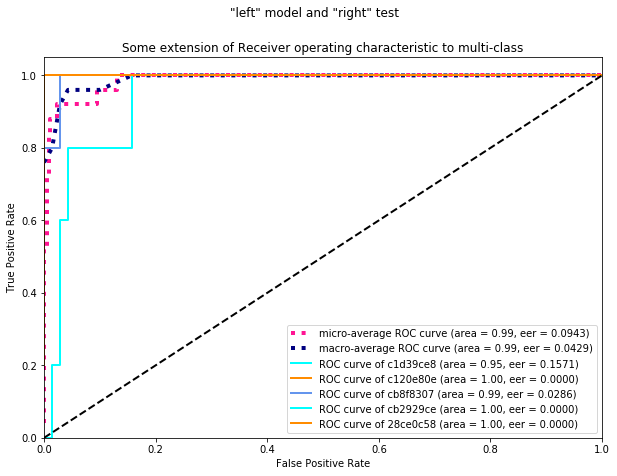

In [158]:
# Plot all ROC curves
fig = plt.figure(figsize=(10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f}, eer = {2:0.4f})'
             ''.format(spk_labels[i], roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.suptitle('"left" model and "right" test')
plt.legend(loc="lower right")
plt.show()